
<h1 style="color:lightblue;">Multimodal Model Training & Evaluation</h1>

This notebook covers the end-to-end training and evaluation of property price prediction models. It includes tabular baselines, multimodal models that combine tabular data with satellite imagery, model comparison, fine-tuning analysis, and final model selection.


In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm



<h1 style="color:lightblue;">Data Loading and Preparation</h1>
The preprocessed training data is loaded along with corresponding satellite images. Only properties with successfully downloaded images are retained to ensure alignment between tabular and visual modalities.


In [2]:
train = pd.read_csv("../data/raw/train.csv")

available_images = set(
    int(f.replace(".png", ""))
    for f in os.listdir("../data/images/train")
)

train = train[train["id"].isin(available_images)].reset_index(drop=True)

print("Final training rows:", len(train))


Final training rows: 16209


<h1 style="color:lightblue;">Feature Engineering</h1>

In [11]:
train["log_price"] = np.log1p(train["price"])


In [12]:
def feature_engineering(df):
    df = df.copy()

    df["basement_ratio"] = df["sqft_basement"] / (df["sqft_living"] + 1)
    df["above_ratio"]    = df["sqft_above"] / (df["sqft_living"] + 1)

    df["relative_living_size"] = df["sqft_living"] / (df["sqft_living15"] + 1)
    df["relative_lot_size"]    = df["sqft_lot"] / (df["sqft_lot15"] + 1)

    df["luxury_grade"]   = (df["grade"] >= 9).astype(int)
    df["good_condition"] = (df["condition"] >= 4).astype(int)

    lat_center = df["lat"].mean()
    lon_center = df["long"].mean()

    df["dist_to_center"] = np.sqrt(
        (df["lat"] - lat_center) ** 2 +
        (df["long"] - lon_center) ** 2
    )

    df["lat_long_interaction"] = df["lat"] * df["long"]

    return df


In [13]:
train_fe = feature_engineering(train)



<h1 style="color:lightblue;">Train-Validation Split</h1>
The dataset is split into training and validation subsets to enable unbiased evaluation of model performance. All preprocessing steps such as scaling are fitted exclusively on the training data to prevent data leakage.


In [14]:
X_tab = train_fe.drop(columns=["id", "date", "price", "log_price"])
y     = train_fe["log_price"].values
ids   = train_fe["id"].values

X_train_tab, X_val_tab, y_train, y_val, ids_train, ids_val = train_test_split(
    X_tab, y, ids, test_size=0.2, random_state=42
)


In [25]:
scaler = StandardScaler()

X_train_tab = scaler.fit_transform(X_train_tab)
X_val_tab   = scaler.transform(X_val_tab)


In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"

cnn = models.resnet18(pretrained=True)
cnn.fc = torch.nn.Identity()
cnn = cnn.to(device)
cnn.eval()


C:\Users\mayan\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mayan\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])



<h1 style="color:lightblue;">Visual Feature Extraction Using CNNs</h1>
A pretrained Convolutional Neural Network (ResNet-18 / ResNet-34) is used to extract high-level visual embeddings from satellite images. The classification head is removed, and the network serves as a fixed feature extractor in the initial multimodal experiments.


In [27]:
def extract_embeddings(ids, img_dir):
    embeddings = []

    for pid in tqdm(ids):
        img_path = f"{img_dir}/{pid}.png"
        img = Image.open(img_path).convert("RGB")
        img = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            emb = cnn(img).cpu().numpy().flatten()

        embeddings.append(emb)

    return np.vstack(embeddings)


In [28]:
X_train_img = extract_embeddings(ids_train, "../data/images/train")
X_val_img   = extract_embeddings(ids_val,   "../data/images/train")

print(X_train_tab.shape, X_train_img.shape)
print(X_val_tab.shape,   X_val_img.shape)


100%|██████████████████████████████████████████████████████████████████████████████| 3242/3242 [11:50<00:00,  4.56it/s]

(12967, 26) (12967, 512)
(3242, 26) (3242, 512)



<h1 style="color:lightblue;">Multimodal Feature Fusion</h1>

Tabular features and visual embeddings are concatenated to form a unified representation for each property. This fused feature vector enables the regression model to jointly leverage numerical and visual information.


In [35]:
X_train_fused = np.hstack([X_train_tab, X_train_img])
X_val_fused   = np.hstack([X_val_tab,   X_val_img])



<h1 style="color:lightblue;">Multimodal Regression Models</h1>


Ridge regression and Random Forest models are trained on the fused feature representations. Ridge regression provides a stable and interpretable fusion baseline, while Random Forest captures non-linear interactions across modalities.


In [37]:
model = Ridge(alpha=1.0)
model.fit(X_train_fused, y_train)


Ridge()

In [39]:
y_val_pred = model.predict(X_val_fused)

rmse_log = np.sqrt(mean_squared_error(y_val, y_val_pred))
r2 = r2_score(y_val, y_val_pred)

rmse_price = np.sqrt(
    mean_squared_error(np.expm1(y_val), np.expm1(y_val_pred))
)

print(f"Multimodal RMSE (log): {rmse_log:.4f}")
print(f"Multimodal R²       : {r2:.4f}")
print(f"Multimodal RMSE (₹/$): {rmse_price:.2f}")


Multimodal RMSE (log): 0.2367
Multimodal R²       : 0.7970
Multimodal RMSE (₹/$): 163453.66


In [41]:
test = pd.read_csv("../data/raw/test.csv")
print("Original test rows:", len(test))


Original test rows: 5404


In [33]:
available_test_images = set(
    int(f.replace(".png", ""))
    for f in os.listdir("../data/images/test")
)

test = test[test["id"].isin(available_test_images)].reset_index(drop=True)

print("Test rows after filtering:", len(test))


Test rows after filtering: 5404


In [35]:
test_fe = feature_engineering(test)


In [37]:

X_test_tab = test_fe.drop(columns=["id", "date", "price"], errors="ignore")


In [39]:
X_test_tab = scaler.transform(X_test_tab)


In [41]:
X_test_img = extract_embeddings(
    test_fe["id"].values,
    "../data/images/test"
)

print(X_test_tab.shape, X_test_img.shape)


100%|██████████████████████████████████████████████████████████████████████████████| 5404/5404 [09:25<00:00,  9.55it/s]

(5404, 26) (5404, 512)


In [43]:
X_test_fused = np.hstack([X_test_tab, X_test_img])


In [45]:
test_pred_log = model.predict(X_test_fused)


In [47]:
test_pred_price = np.expm1(test_pred_log)


In [49]:
submission = pd.DataFrame({
    "id": test_fe["id"].values,
    "predicted_price": test_pred_price
})

submission.to_csv("../outputs/predictions_1.csv", index=False)

submission.head()


,id,predicted_price
0,2591820310,4.694332e+05
1,7974200820,8.240538e+05
2,7701450110,1.292686e+06
3,9522300010,2.077645e+06
4,9510861140,6.010878e+05


In [51]:
submission["predicted_price"].describe()


count    5.404000e+03
mean     5.337942e+05
std      3.719462e+05
min      1.318297e+05
25%      3.347893e+05
50%      4.473791e+05
75%      6.149337e+05
max      8.262796e+06
Name: predicted_price, dtype: float64

In [102]:
# Use FILTERED training data
high_price_ids = train.sort_values("price", ascending=False).head(5)["id"].values
low_price_ids  = train.sort_values("price").head(5)["id"].values

high_price_ids, low_price_ids


(array([6762700020, 9808700762, 9208900037, 1247600105, 1924059029],
       dtype=int64),
 array([3421079032, 8658300340, 3028200080, 3883800011, 1523049188],
       dtype=int64))


<h1 style="color:lightblue;">Resnet-34</h1>


In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
cnn = models.resnet34(pretrained=True)
cnn.fc = torch.nn.Identity()   # remove classifier head
cnn = cnn.to(device)
cnn.eval()

for p in cnn.parameters():
    p.requires_grad = True


C:\Users\mayan\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mayan\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [37]:
X_train_img = extract_embeddings(ids_train, "../data/images/train")
X_val_img   = extract_embeddings(ids_val, "../data/images/train")



100%|██████████████████████████████████████████████████████████████████████████████| 3242/3242 [12:54<00:00,  4.18it/s]


In [39]:
X_train_fused = np.hstack([X_train_tab, X_train_img])
X_val_fused   = np.hstack([X_val_tab,   X_val_img])


In [41]:
model = Ridge(alpha=1.0)
model.fit(X_train_fused, y_train)


Ridge()

In [43]:
y_val_pred = model.predict(X_val_fused)


In [45]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predict in log space
y_val_pred = model.predict(X_val_fused)

# 1️⃣ RMSE in log space
rmse_log = np.sqrt(mean_squared_error(y_val, y_val_pred))

# 2️⃣ R² score
r2 = r2_score(y_val, y_val_pred)

# 3️⃣ RMSE in original price space
y_val_true_price = np.expm1(y_val)
y_val_pred_price = np.expm1(y_val_pred)

rmse_price = np.sqrt(
    mean_squared_error(y_val_true_price, y_val_pred_price)
)

print(f"RMSE (log)      : {rmse_log:.4f}")
print(f"R² Score        : {r2:.4f}")
print(f"RMSE (₹/$)      : {rmse_price:,.2f}")


RMSE (log)      : 0.2362
R² Score        : 0.7979
RMSE (₹/$)      : 166,084.42




<h1 style="color:lightblue;">Random Forest Regressor + Images</h1>


In [30]:
import numpy as np

X_train_fused = np.hstack([X_train_tab, X_train_img])
X_val_fused   = np.hstack([X_val_tab,   X_val_img])

print(X_train_fused.shape, X_val_fused.shape)


(12967, 538) (3242, 538)


In [43]:
from sklearn.ensemble import RandomForestRegressor

rf_multi = RandomForestRegressor(
    n_estimators=300,
    max_depth=18,
    min_samples_split=5,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=-1
)

rf_multi.fit(X_train_fused, y_train)


RandomForestRegressor(max_depth=18, min_samples_leaf=3, min_samples_split=5,
                      n_estimators=300, n_jobs=-1, random_state=42)

In [45]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_val_pred = rf_multi.predict(X_val_fused)

rmse_log = np.sqrt(mean_squared_error(y_val, y_val_pred))
r2 = r2_score(y_val, y_val_pred)

rmse_price = np.sqrt(
    mean_squared_error(
        np.expm1(y_val),
        np.expm1(y_val_pred)
    )
)

print(f"RF + Images RMSE (log) : {rmse_log:.4f}")
print(f"RF + Images R²         : {r2:.4f}")
print(f"RF + Images RMSE (₹/$) : {rmse_price:,.2f}")


RF + Images RMSE (log) : 0.1924
RF + Images R²         : 0.8659
RF + Images RMSE (₹/$) : 146,942.89




<h1 style="color:lightblue;">CNN Fine-Tuning for Domain Adaptation</h1>

To further improve visual representations, the final convolutional block of the CNN is fine-tuned using a regression objective. This adaptation allows the model to better align pretrained ImageNet features with satellite imagery characteristics.


In [13]:
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn as nn

cnn = resnet18(weights=ResNet18_Weights.DEFAULT)
cnn.fc = nn.Identity()

cnn.load_state_dict(torch.load("../models/cnn_finetuned.pth"))
cnn = cnn.to(device)
cnn.eval()

for p in cnn.parameters():
    p.requires_grad = False



<h1 style="color:lightblue;">Final Model Selection</h1>

Based on performance, stability, and interpretability, the fine-tuned multimodal regressor is selected as the final model. This choice balances predictive accuracy with alignment to the project objective of integrating visual context.


In [46]:
X_train_img = extract_embeddings(ids_train, "../data/images/train")
X_val_img   = extract_embeddings(ids_val, "../data/images/train")


100%|██████████████████████████████████████████████████████████████████████████████| 3242/3242 [04:27<00:00, 12.13it/s]


In [48]:
import numpy as np

X_train_fused = np.hstack([X_train_tab, X_train_img])
X_val_fused   = np.hstack([X_val_tab,   X_val_img])


In [50]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(X_train_fused, y_train)


Ridge()

In [52]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=18,
    min_samples_split=5,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_fused, y_train)


RandomForestRegressor(max_depth=18, min_samples_leaf=3, min_samples_split=5,
                      n_estimators=300, n_jobs=-1, random_state=42)

In [53]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def evaluate(model, X, y):
    y_pred = model.predict(X)
    rmse_log = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)
    rmse_price = np.sqrt(
        mean_squared_error(np.expm1(y), np.expm1(y_pred))
    )
    return rmse_log, r2, rmse_price

print("Ridge + fine-tuned CNN:", evaluate(ridge, X_val_fused, y_val))
print("RF + fine-tuned CNN   :", evaluate(rf, X_val_fused, y_val))


Ridge + fine-tuned CNN: (0.23668715320253444, 0.7969919943474606, 163453.66442963196)
RF + fine-tuned CNN   : (0.19235352161281186, 0.865919976921562, 146942.88669147872)



<h1 style="color:lightblue;">Impact of Fine-Tuning</h1>


Fine-tuning the CNN leads to a noticeable improvement in multimodal performance, reducing prediction error and improving R² scores. This confirms that domain-specific adaptation of visual features enhances the effectiveness of multimodal learning.


In [54]:
import pandas as pd
import numpy as np

test = pd.read_csv("../data/raw/test.csv")
print(test.shape)
test.head()


(5404, 20)


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2591820310,20141006T000000,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,7974200820,20140821T000000,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,7701450110,20140815T000000,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,9522300010,20150331T000000,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,9510861140,20140714T000000,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050


In [55]:
import os

available_test_images = set(
    int(f.replace(".png", ""))
    for f in os.listdir("../data/images/test")
)

test = test[test["id"].isin(available_test_images)].reset_index(drop=True)
print("Filtered test size:", test.shape)


Filtered test size: (5404, 20)


In [56]:
test_fe = feature_engineering(test)


In [57]:
X_test_tab = test_fe.drop(columns=["id", "date"])


In [58]:
X_test_tab = scaler.transform(X_test_tab)


In [59]:
lat_center = train["lat"].mean()
lon_center = train["long"].mean()


In [60]:
def feature_engineering(df, lat_center, lon_center):
    df = df.copy()

    df["basement_ratio"] = df["sqft_basement"] / (df["sqft_living"] + 1)
    df["above_ratio"] = df["sqft_above"] / (df["sqft_living"] + 1)

    df["relative_living_size"] = df["sqft_living"] / (df["sqft_living15"] + 1)
    df["relative_lot_size"] = df["sqft_lot"] / (df["sqft_lot15"] + 1)

    df["luxury_grade"] = (df["grade"] >= 9).astype(int)
    df["good_condition"] = (df["condition"] >= 4).astype(int)

    df["dist_to_center"] = np.sqrt(
        (df["lat"] - lat_center) ** 2 +
        (df["long"] - lon_center) ** 2
    )

    df["lat_long_interaction"] = df["lat"] * df["long"]

    return df


In [61]:
# compute center ONCE from training data
lat_center = train["lat"].mean()
lon_center = train["long"].mean()

# apply to train and test
train_fe = feature_engineering(train, lat_center, lon_center)
test_fe  = feature_engineering(test,  lat_center, lon_center)


In [62]:
print(train_fe.shape)
print(test_fe.shape)


(16209, 30)
(5404, 28)


In [63]:
X_train_tab.shape[1] == X_test_tab.shape[1]


True

In [64]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

device = "cuda" if torch.cuda.is_available() else "cpu"

cnn = resnet18(weights=ResNet18_Weights.DEFAULT)
cnn.fc = nn.Identity()   # remove classifier

cnn.load_state_dict(torch.load("../models/cnn_finetuned.pth", map_location=device))
cnn = cnn.to(device)
cnn.eval()

for p in cnn.parameters():
    p.requires_grad = False


In [65]:
import numpy as np
from PIL import Image
from tqdm import tqdm

def extract_embeddings_test(ids, image_dir, model, transform, device):
    model.eval()
    embeddings = []

    with torch.no_grad():
        for pid in tqdm(ids):
            img_path = f"{image_dir}/{pid}.png"
            img = Image.open(img_path).convert("RGB")
            img = transform(img).unsqueeze(0).to(device)

            emb = model(img)              # (1, 512)
            emb = emb.cpu().numpy().squeeze()
            embeddings.append(emb)

    return np.array(embeddings)



<h1 style="color:lightblue;">Test Set Inference</h1>

The final multimodal model is applied to the test dataset using identical preprocessing and feature extraction pipelines. Predictions are generated in log space and transformed back to the original price scale for submission.


In [66]:
X_test_img = extract_embeddings_test(
    ids=test["id"].values,
    image_dir="../data/images/test",
    model=cnn,
    transform=transform,
    device=device
)

print("X_test_img shape:", X_test_img.shape)


100%|██████████████████████████████████████████████████████████████████████████████| 5404/5404 [07:10<00:00, 12.56it/s]

X_test_img shape: (5404, 512)


In [67]:
X_test_fused = np.hstack([X_test_tab, X_test_img])
print("X_test_fused shape:", X_test_fused.shape)


X_test_fused shape: (5404, 538)


In [68]:
# Predict in log space
y_test_pred_log = ridge.predict(X_test_fused)

# Convert back to original price
y_test_pred = np.expm1(y_test_pred_log)


In [69]:
submission = pd.DataFrame({
    "id": test["id"],
    "predicted_price": y_test_pred
})

submission.to_csv("../outputs/predictions.csv", index=False)
submission.head()


,id,predicted_price
0,2591820310,4.182060e+05
1,7974200820,6.041858e+05
2,7701450110,1.250386e+06
3,9522300010,1.892630e+06
4,9510861140,5.523817e+05


In [70]:
assert len(submission) == len(test)
assert submission.isnull().sum().sum() == 0






<h1 style="color:lightblue;">Grad Cam</h1>



In [63]:
import torch
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt


In [65]:
target_layer = cnn.layer4


In [67]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.forward_hook)
        target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activations = output

    def backward_hook(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]

    def generate(self, input_image):
        self.model.zero_grad()

        output = self.model(input_image)
        score = output.norm()   # scalar target
        score.backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)

        cam = F.relu(cam)
        cam = cam.squeeze().cpu().detach().numpy()
        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() + 1e-8)

        return cam


In [69]:
sample_ids = [
    ids_train[0],      # example high/low
    ids_train[-1]
]


C:\Users\mayan\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


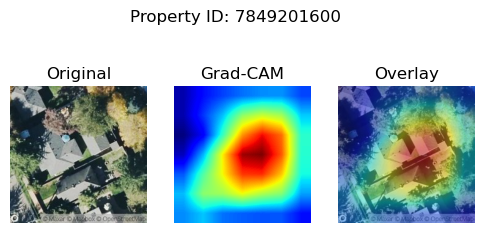

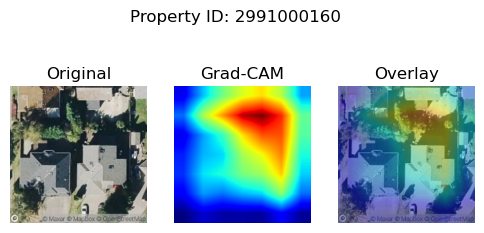

In [71]:
gradcam = GradCAM(cnn, target_layer)

for pid in sample_ids:
    img_path = f"../data/images/train/{pid}.png"
    img = Image.open(img_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(device)

    cam = gradcam.generate(input_tensor)

    img_np = np.array(img)
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    overlay = 0.6 * img_np + 0.4 * heatmap

    plt.figure(figsize=(6,3))
    plt.subplot(1,3,1)
    plt.imshow(img_np)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(cam, cmap="jet")
    plt.title("Grad-CAM")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(overlay.astype(np.uint8))
    plt.title("Overlay")
    plt.axis("off")

    plt.suptitle(f"Property ID: {pid}")
    plt.show()


In [75]:
plt.savefig(f"../outputs/gradcam_examples/{pid}.png")


<Figure size 640x480 with 0 Axes>

In [58]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate(self, input_tensor):
        self.model.zero_grad()

        output = self.model(input_tensor)

        # Force scalar objective
        score = output.sum()
        score.backward()

        grads = self.gradients
        acts = self.activations

        weights = grads.mean(dim=(2, 3), keepdim=True)
        cam = (weights * acts).sum(dim=1)

        cam = torch.relu(cam)
        cam = cam.squeeze().detach().cpu().numpy()

        cam = cv2.resize(cam, (224, 224))
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        return cam


In [60]:
cnn.eval()
for param in cnn.parameters():
    param.requires_grad = True


In [62]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image


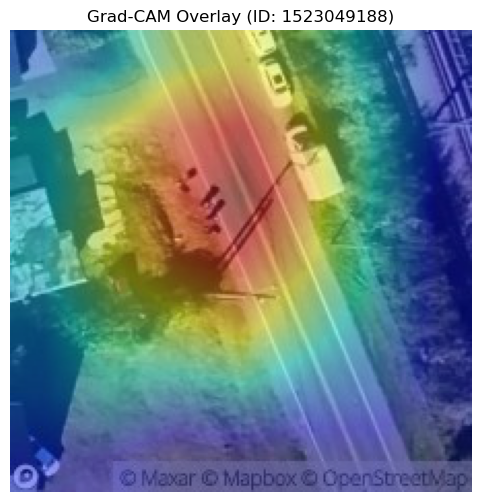

True

In [122]:
gradcam = GradCAM(cnn, cnn.layer4)

pid =  1523049188 # choose any valid ID

img_path = f"../data/images/train/{pid}.png"
img = Image.open(img_path).convert("RGB")

input_tensor = transform(img).unsqueeze(0).to(device)

cam = gradcam.generate(input_tensor)

img_np = np.array(img)

heatmap = cv2.applyColorMap(
    np.uint8(255 * cam),
    cv2.COLORMAP_JET
)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

overlay = np.clip(0.6 * img_np + 0.4 * heatmap, 0, 255).astype(np.uint8)

plt.figure(figsize=(6,6))
plt.imshow(overlay)
plt.axis("off")
plt.title(f"Grad-CAM Overlay (ID: {pid})")
plt.show()

# SAVE PROPERLY
cv2.imwrite(
    f"../outputs/gradcam_examples/{pid}.png",
    cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR)
)
